In [1]:
# Papermill params
ratio = 0.9          # Train-Test split ratio
attempt = 0        # Number of times to run
width = 512
depth = 2
learning_rate = 1e-2
dropout = 0.05
regularization = 1e-7
epsilon = 1e-7
attempts = 20

In [ ]:
import random
import matplotlib.pyplot as plt
import seaborn as sns
colors = sns.color_palette("husl", 8)

# Neural network

In this notebook we evaluate convergence of the individual ensembles by comparing timescales for limited numbers of trajectories.

In [2]:
%run model.py

/home/thomas/anaconda3/envs/tf/lib/python3.5/site-packages/pyemma/__init__.py:130: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.5.7, you have 2.5.4.
  .format(latest=latest, current=current), category=UserWarning)


In [3]:
def statdist(X: np.ndarray) -> np.ndarray:
    """
    Calculate the equilibrium distribution of a transition matrix.
    
    Parameters
    ----------
    X
        Row-stochastic transition matrix
    
    Returns
    -------
    mu
        Stationary distribution, i.e. the left
        eigenvector associated with eigenvalue 1.
    
    """
    ev, evec = eig(X, left=True, right=False)
    mu = evec.T[ev.argmax()]
    mu /= mu.sum()
    return mu

In [4]:
def test_split(data: MaybeListType[np.ndarray], lag: int, p: float=0.1, mask: Optional[np.ndarray]=None):
    data = make_list(data)
    lengths = np.array([len(d) for d in data])
    nframes = lengths.sum()
    
    inds = np.empty((nframes, 4), dtype=np.int)
    inds[:, 0] = np.repeat(np.arange(len(data), dtype=np.int), lengths)
    inds[:, 1] = np.concatenate([np.arange(n) for n in lengths])
    inds[:, 2] = np.arange(nframes, dtype=np.int)
    inds[:, 3] = np.zeros_like(inds[:, 0]) if mask is None else mask
    inds = unflatten(inds, lengths=[lengths])
    
    # Local (frame) shuffling
    shuf_traj_inds = [np.random.choice(
        d[:, 1], size=d.shape[FRAMES], replace=False) for d in inds]
    
    # Sort out too short trajectories, split out lagged part
    n_pairs = 0
    xt, xttau = [], []
    for i, traj in enumerate(inds):
        n_points = traj.shape[FRAMES]

        # We'll just skip super short trajectories for now
        shuf_traj_inds[i] = shuf_traj_inds[i][shuf_traj_inds[i] < (n_points - lag)]
        if n_points <= lag:
            continue
                
        n_pairs += n_points - lag
        xt.append(traj[:n_points - lag][shuf_traj_inds[i]])
        xttau.append(traj[lag:n_points][shuf_traj_inds[i]])
        
    # Shuffle externally
    shuf_full_inds = np.random.choice(
        np.arange(n_pairs, dtype=np.int), size=n_pairs, replace=False)
    xt_shuf = np.vstack(xt)[shuf_full_inds]
    xttau_shuf = np.vstack(xttau)[shuf_full_inds]
    
    # These are the entries for the test set
    n_frames_test = int(xt_shuf.shape[FRAMES] * p)
    inds_t = xt_shuf[:n_frames_test]
    inds_ttau = xttau_shuf[:n_frames_test]
    data_flat = np.vstack(data)
    test_xt, test_xttau = data_flat[inds_t[:, 2]], data_flat[inds_ttau[:, 2]]
    
    # Mask out unwanted frames with NaNs
    mask_pair = xt_shuf[:, 3] | xttau_shuf[:, 3]
    test_xt[mask_pair[:n_frames_test]] = np.nan
    test_xttau[mask_pair[:n_frames_test]] = np.nan
    
    # We can't just remove our test frame pairs, as the training set
    # would then be out of sync! So we replace the test samples with
    # NaNs instead, we can check for those later in the DataGenerator.
    data_flat[np.union1d(inds_t[:, 2], inds_ttau[:, 2])] = np.nan
    data_train_valid = unflatten(data_flat, lengths=[lengths])
        
    return data_train_valid, (test_xt, test_xttau)

## Data
### Trajectories
Trajectories were acquired in five rounds of 1024 simulations each, totalling 5119 runs (one simulation failed to run) at 278 K in the $NVT$ ensemble. Postprocessing involved removing water, subsampling to 250 ps timesteps, and making molecules whole.

In [5]:
sim_names = ("holo", "control", "apo")
top, trajs = {}, {}
trajs = {k: sorted(glob("trajectories/{0}/r?/traj*.xtc".format(k))) for k in sim_names}
top = {k: "trajectories/{0}/topol.gro".format(k) for k in sim_names}
KBT = 2.311420 # 278 K
nres = 42
traj_rounds = {
    "apo": [1024, 1023, 1024, 1024, 1024],
    "holo": [1023, 1024, 32],
    "control": [1024, 1023]
}

# This is only really necessary for the residues in the plots
topo = md.load_topology(top["apo"])

We use minimum distances as features for the neural network:

In [6]:
allpairs = np.asarray(list(itertools.combinations(range(nres), 2)))
inpcon = {}
for k in sim_names:
    feat = pe.coordinates.featurizer(top[k])
    feat.add_residue_mindist(residue_pairs=allpairs)
    inpcon[k] = pe.coordinates.source(trajs[k], feat)

In [7]:
lengths, nframes = {}, {}
for i, k in enumerate(sim_names):
    lengths[k] = sort_lengths(inpcon[k].trajectory_lengths(), traj_rounds[k])
    nframes[k] = inpcon[k].trajectory_lengths().sum()

In [8]:
print("\t\t" + "\t\t".join(sim_names))
print("\n".join((
    "Trajs: \t\t" + "\t\t".join("{0}".format(len(trajs[k])) for k in sim_names),
    "Frames: \t" + "\t\t".join("{0}".format(nframes[k]) for k in sim_names),
    "Time: \t\t" + "\t".join("{0:5.3f} µs".format(inpcon[k].trajectory_lengths().sum() * 0.00025)
                           for k in sim_names)
)))

		holo		control		apo
Trajs: 		2079		2047		5119
Frames: 	1225868		1114503		1259172
Time: 		306.467 µs	278.626 µs	314.793 µs


## VAMPNet
VAMPNet[1] is composed of two lobes, one reading the system features $\mathbf{x}$ at a timepoint $t$ and the other after some lag time $\tau$. In this case the network reads all minimum inter-residue distances (780 values) and sends them through 5 layers with 256 nodes each. The final layer uses between 2 and 8 *softmax* outputs to yield a state assignment vector $\chi: \mathbb{R}^m \to \Delta^{n}$ where $\Delta^{n} = \{ s \in \mathbb{R}^n \mid 0 \le s_i \le 1, \sum_i^n s_i = 1 \}$ representing the probability of a state assignment. One lobe thus transforms a system state into a state occupation probability. We can also view this value as a kind of reverse ambiguity, i.e. how sure the network is that the system is part of a certain cluster. These outputs are then used as the input for the VAMP scoring function. We use the new enhanced version with physical constraints[2], particularly the ones for positive entries and reversibility.

[1] Mardt, A., Pasquali, L., Wu, H. & Noé, F. VAMPnets for deep learning of molecular kinetics. Nat Comms 1–11 (2017). doi:10.1038/s41467-017-02388-1

[2] Mardt, A., Pasquali, L., Noé, F. & Wu, H. Deep learning Markov and Koopman models with physical constraints. arXiv:1912.07392 [physics] (2019).

### Data preparation
We use minimum residue distances as input ($\frac{N(N-1)}{2}$ values, where $N$ is the number of residues) and first normalize the data:

In [9]:
for k in sim_names:
    filename = "intermediate/mindist-all-{0}.npy".format(k)
    if not os.path.exists(filename):
        print("No mindist file for {0} ensemble, calculating from scratch...".format(k))
        con = np.vstack(inpcon[k].get_output())
        np.save(filename, con)

In [10]:
idx = np.triu_indices(nres, k=1)
mat = np.zeros((nres, nres), dtype=np.int)
full_flat, full_data = {}, {}
for k in sim_names:
    raw = np.load("intermediate/mindist-all-{0}.npy".format(k))
    mat[idx] = np.arange(raw.shape[1])
    redinds = mat[np.triu_indices_from(mat, k=3)]
    full_flat[k] = ((raw - raw.mean(axis=0)) / raw.std(axis=0))[:, redinds]
    full_data[k] = unflatten(full_flat[k], lengths[k])

### Neural network hyperparameters
To allow for a larger hyperparameter search space, we use the self-normalizing neural network approach by Klambauer *et al.* [2], thus using SELU units, `AlphaDropout` and normalized `LeCun` weight initialization. The other hyperparameters are defined at the beginning of this notebook.

[2] Klambauer, G., Unterthiner, T., Mayr, A. & Hochreiter, S. Self-Normalizing Neural Networks. arXiv.org cs.LG, (2017).

In [11]:
activation = "selu"                 # NN activation function
init = "lecun_uniform"              # NN weight initialization
lag = 20                            # Lag time
n_epoch = 100                       # Max. number of epochs
n_epoch_s = 10000                   # Max. number of epochs for S optimization
n_batch = 10000                     # Training batch size
n_dims = full_data[k][0].shape[1]   # Input dimension
nres = 42                           # Number of residues
epsilon = 1e-7                      # Floating point noise
dt = 0.25                           # Trajectory timestep in ns
steps = 6                           # CK test steps
bs_frames = 1000000                 # Number of frames in the bootstrap sample
n_tries = 1                         # Number of training attempts for each model, we pick the best scoring one

# outsizes = np.array([4, 2, 3, 5, 6])
outsizes = np.array([8, 10, 12, 14, 16])
lags = np.array([1, 2, 5, 10, 20, 50, 100])

### Bound ensemble
We filter out unbound frames to avoid issues with potential non-equilibrium conditions, as we see essentially no unbinding events.

In [12]:
inter_pairs = list(itertools.product(range(nres), (nres,)))
intercon = {}
for k in ("holo", "control"):
    feat = pe.coordinates.featurizer(top[k])
    feat.add_residue_mindist(residue_pairs=inter_pairs)
    intercon[k] = pe.coordinates.source(trajs[k], feat)

In [13]:
inter_con = {}
for k in ("holo", "control"):
    filename = "intermediate/mindist-inter-all-{0}.npy".format(k)
    if not os.path.exists(filename):
        print("No mindist file for {0} ensemble, calculating from scratch...".format(k))
        inter_con[k] = np.vstack(intercon[k].get_output())
        np.save(filename, inter_con)
    else:
        inter_con[k] = np.load(filename)

In [14]:
cutoff = 0.5  # Compromise given the above plot
masks = {k: (inter_con[k] < cutoff).any(axis=1) for k in ("holo",)}
masks.update({k: np.full(full_flat[k].shape[0], True) for k in ("apo", "control")})

In [15]:
input_data, input_flat, test_data = {}, {}, {}
for k in ("holo", "apo", "control"):
    filename = "intermediate/input-mask-{0}.npz".format(k)
    if not os.path.exists(filename):
        print("No input file for {0} ensemble, resplitting...".format(k))
        input_data[k], test_data[k] = test_split(full_data[k], lag=lag, mask=~masks[k])
        input_flat[k] = np.vstack(input_data[k])
        input_flat[k][~masks[k]] = np.nan
        np.savez(filename, data=input_flat[k], test_t=test_data[k][0], test_ttau=test_data[k][1])
    else:
        print("Reading existing input file for {0} ensemble...".format(k))
        raw = np.load(filename)
        input_flat[k], test_data[k] = raw["data"], (raw["test_t"], raw["test_ttau"])
        input_data[k] = unflatten(input_flat[k], lengths=lengths[k])

Reading existing input file for holo ensemble...
Reading existing input file for apo ensemble...
Reading existing input file for control ensemble...


### Run
We evaluate the Koopman model with varying numbers of trajectories and compare the implied timescales.

In [46]:
n = 2
for k in ("holo", "control"):
    filename = "intermediate/k-conv-{0}-{1}-1.npy".format(k, n)
    n_trajs = np.array([1024, 2048])
    k_conv = np.empty((len(n_trajs), attempts, n, n))
    for j, nt in enumerate(n_trajs):
        for i in range(3):
            generator = DataGenerator(input_data[k][:nt])
            print("Analysing trajs={0} n={1} i={2}...".format(j, n, i), end="\r")
            koop = KoopmanModel(n=n, network_lag=lag, verbose=0, nnargs=dict(
                width=width, depth=depth, learning_rate=learning_rate,
                regularization=regularization, dropout=dropout,
                batchnorm=False, lr_factor=2e-2))
            koop.load("models/model-ve-{0}-{1}-{2}.hdf5".format(k, n, i))
            koop.generator = generator
            k_conv[j, i] = koop.estimate_koopman(lag=50)
            del koop
            gc.collect()
    np.save(filename, k_conv)

Restoring model weights from the end of the best epoch
Epoch 00232: early stopping
Restoring model weights from the end of the best epoch
Epoch 00818: early stopping
Lag loss: -1.9996654987335205
Restoring model weights from the end of the best epoch
Epoch 00427: early stopping
Restoring model weights from the end of the best epoch
Epoch 00389: early stopping
Lag loss: -1.9883699417114258
Restoring model weights from the end of the best epoch
Epoch 00070: early stopping
Restoring model weights from the end of the best epoch
Epoch 00302: early stopping
Lag loss: -1.9999778270721436
Restoring model weights from the end of the best epoch
Epoch 00051: early stopping
Restoring model weights from the end of the best epoch
Epoch 00452: early stopping
Lag loss: -1.9951941967010498
Restoring model weights from the end of the best epoch
Epoch 00537: early stopping
Restoring model weights from the end of the best epoch
Epoch 00134: early stopping
Lag loss: -1.9904100894927979
Restoring model weig

Concatenate partial runs:

In [52]:
n = 2
k_conv = {}
for k in ("holo", "control"):
    k_conv[k] = np.concatenate([np.load("intermediate/k-conv-{0}-{1}.npy".format(k, n))[:, :2],
                                np.load("intermediate/k-conv-{0}-{1}-1.npy".format(k, n))[:, :3]], axis=1)

In [55]:
its_conv = {}
for k in ("holo", "control"):
    n_rounds = len(k_conv[k])
    its_conv[k] = np.empty((n_rounds, 5, n - 1))
    for j in range(n_rounds):
        for i in range(5):
            its_conv[k][j, i] = -50 * dt / np.log(np.sort(np.linalg.eigvals(k_conv[k][j, i]))[::-1])[1:]

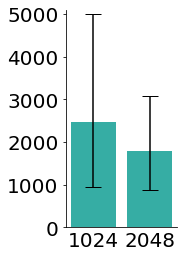

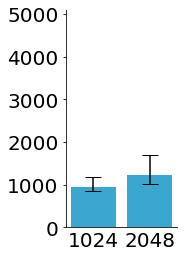

In [75]:
for i, k in enumerate(("holo", "control")):
    fig = plt.figure(figsize=(2, 4))
    ax = fig.add_subplot(111)
    its_conv_m = its_conv[k].squeeze().mean(axis=1)
    its_conv_l, its_conv_h = np.percentile(its_conv[k].squeeze(), (2.5, 97.5), axis=1)
    ax.bar([0, 1], its_conv_m, yerr=[its_conv_m - its_conv_l, its_conv_h - its_conv_m],
           capsize=8, color=colors[i + 4])
    ax.set_xticklabels([0, 1024, 2048], fontsize=20)
    ax.set_ylim(0, 5100)
    ax.set_yticks(np.arange(0, 6000, 1000))
    ax.tick_params(axis="x", length=0)
    ax.tick_params(axis="both", labelsize=20)
    sns.despine(ax=ax)
    plt.savefig("figs/conv-bar-{0}.pdf".format(k), bbox_inches="tight", transparent=True)
    plt.savefig("figs/conv-bar-{0}.svg".format(k), bbox_inches="tight", transparent=True)